In [7]:
from radiomics import firstorder, shape, glcm
import os, sys
import numpy as np
import SimpleITK as sitk
import pandas as pd

def normalizedImage(image):
    im_arr = sitk.GetArrayFromImage(image).astype(float)    
    print("Intensity range: ", np.min(im_arr), np.max(im_arr))
    im_arr += np.min(im_arr)
    im_arr *= 256 / np.max(im_arr)
    im = sitk.GetImageFromArray(im_arr.astype(int))
    print("Intensity range: ", np.min(im_arr), np.max(im_arr))
    im.CopyInformation(image)
    return im

filePrefix = "../cleanedUp"
firstOrderFeatures = [("t2_int_10","10Percentile"), 
                 ("t2_int_90","90Percentile"), 
                 ("t2_int_mean", "Mean"), ("t2_int_SD", "StandardDeviation"),
                 ("t2_int_Kur", "Kurtosis"), ("t2_int_Ske", "Skewness")]
shapeFeatures = [("ROI_Vol", "VoxelVolume")]
                 
#                 "t2_int_25", "t2_int_50", "t2_int_mean", \
#"t2_int_75",  , , , "t2_con_10"]

usfFeatures = pd.read_csv(os.path.join(filePrefix,"Challenge_training_T2w.csv"),sep=",")

usfFeatures["Patient"]

imageFiles = ["subject0000.nrrd","subject0001.nrrd"]
subjects = ["0000", "0001"]
maskTypes = ["T_PZ", "F_TZ"]
#maskFileSuffixes = ["subject0000 ROI-1_T_PZ.nrrd", "subject0001 ROI-1_F_TZ.nrrd"]

usfValues = []
prValues = []
subjectValues = []

for (i,s) in enumerate(subjects):
    fullSubjectID = "ProstateX-"+s
    print("\nSubject "+fullSubjectID)
    
    imageFile = os.path.join(filePrefix, "subject%s.nrrd" % s)
    maskFile = os.path.join(filePrefix, "subject%s ROI-1_%s.nrrd" % (s, maskTypes[i]))
    image = sitk.ReadImage(imageFile)
    
    mask = sitk.ReadImage(maskFile)
    ma_arr = sitk.GetArrayFromImage(mask)
    print(np.sum(ma_arr == 1))
    
    sf = shape.RadiomicsShape(image, mask)
    sf.enableFeatureByName('VoxelVolume', True)
    print(sf.execute()["VoxelVolume"]/1000., usfFeatures[usfFeatures["Patient"]==fullSubjectID]['ROI_Vol'].values[0])
    
    fof = firstorder.RadiomicsFirstOrder(image, mask)
    for (usfName,prName) in firstOrderFeatures:
        fof.enableFeatureByName(prName, True)
    prResults = fof.execute()

    for (usfName,prName) in firstOrderFeatures:
        usfValue = usfFeatures[usfFeatures["Patient"]==fullSubjectID][usfName].values[0]
        usfValues.append(usfValue)
        prValues.append(prResults[prName])
        if prName == "Kurtosis":
            prValues[-1] = prValues[-1]-3.
        print(prName, usfValue, prValues[-1])
        subjectValues.append(i+1)
        
    #image = normalizedImage(image)
    
    settings = {"voxelBased": True, "kernelRadius": 2, "binCount": 128}
    gf = glcm.RadiomicsGLCM(image, mask, **settings)
    gf.enableFeatureByName("JointEnergy", True)
    prResults = gf.execute()
   


Feature StandardDeviation is deprecated, use with caution!



Subject ProstateX-0000
1770
1.3275009495019925 1.3275
10Percentile 163.0 163.0
90Percentile 298.0 298.0
Mean 231.0542373 231.0542372881356
StandardDeviation 53.17081486 53.15579273470041
Kurtosis -0.203379836 -0.20619368723903486
Skewness 0.108795153 0.10870293238827056


Feature StandardDeviation is deprecated, use with caution!



Subject ProstateX-0001
484
0.363000259637833 0.3915
10Percentile 107.0 58.0
90Percentile 189.0 217.7
Mean 147.11111110000002 129.03512396694214
StandardDeviation 31.44832631 70.6810202073132
Kurtosis -0.047712769 3.809160217401807
Skewness 0.093829705 1.4963221149990054


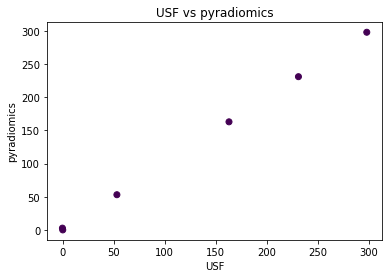

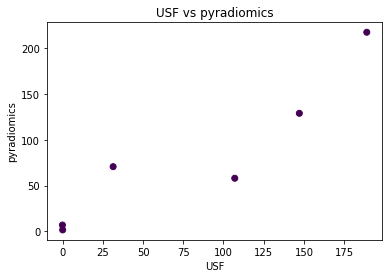

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Plot
plt.scatter(usfValues[:6], prValues[:6], c=subjectValues[:6])
plt.title('USF vs pyradiomics')
plt.xlabel('USF')
plt.ylabel('pyradiomics')
plt.show()

plt.scatter(usfValues[6:], prValues[6:], c=subjectValues[6:])
plt.line()
plt.title('USF vs pyradiomics')
plt.xlabel('USF')
plt.ylabel('pyradiomics')
plt.show()

In [5]:
usfFeatures

,Patient,Contour,Pros_Vol,ROI_Vol,t2_int_10,t2_int_25,t2_int_50,t2_int_mean,t2_int_75,t2_int_90,...,t2_ent_Ske,t2_hom_10,t2_hom_25,t2_hom_50,t2_hom_mean,t2_hom_75,t2_hom_90,t2_hom_SD,t2_hom_Kur,t2_hom_Ske
0,ProstateX-0000,ROI-1_T_PZ,30.737250,1.327500,163.000000,192.000000,230.000000,231.054237,270.000000,298.000000,...,-13.001095,98.0,112.00,128.0,131.134463,148.00,170.0,28.790446,1.771203,0.273468
1,ProstateX-0001,ROI-1_F_TZ,24.419250,0.391500,107.000000,126.000000,146.500000,147.111111,169.000000,189.000000,...,-1.543385,0.0,59.00,87.5,79.831418,108.25,138.0,46.578750,-0.622295,-0.448726
2,ProstateX-0002,ROI-1_T_PZ,25.176000,0.507750,145.000000,167.000000,223.000000,245.140325,308.500000,381.400000,...,-11.894496,90.0,96.00,114.0,116.741507,134.50,151.0,23.437370,-0.020716,0.274204
3,ProstateX-0002,ROI-2_F_PZ,25.176000,0.328500,155.900000,185.000000,219.000000,227.456621,267.000000,311.200000,...,-5.754207,65.0,85.00,104.0,103.710046,129.00,142.0,30.760616,1.427636,-0.707495
4,ProstateX-0003,ROI-1_F_TZ,118.047000,0.726750,113.000008,134.000000,157.000015,158.103210,181.000015,201.000015,...,-0.602841,76.0,86.00,97.0,99.163055,113.00,123.0,19.049691,0.294787,0.440000
5,ProstateX-0003,ROI-2_F_TZ,118.047000,1.127250,120.400008,140.000000,162.000015,160.749845,182.000015,199.600015,...,-0.789258,75.0,87.00,102.0,102.827013,118.00,133.0,20.956823,-0.728457,0.176713
6,ProstateX-0004,ROI-1_F_TZ,134.915620,4.538250,193.000000,223.000000,254.000000,253.065196,283.000000,307.000000,...,-10.241663,51.0,59.00,69.0,71.061477,81.00,94.0,17.256260,0.708979,0.419984
7,ProstateX-0005,ROI-1_T_PZ,30.735750,0.120750,185.200015,223.500015,280.000000,287.795051,340.000031,410.000031,...,-8.121733,86.8,99.00,114.0,113.937888,128.00,151.0,25.680413,3.730292,-0.677908
8,ProstateX-0005,ROI-2_T_PZ,30.735750,0.138750,121.200008,153.500015,196.000015,201.502715,241.500015,288.400000,...,-2.532140,27.6,65.00,85.0,84.081081,105.00,139.0,38.775117,0.306253,-0.433758
9,ProstateX-0005,ROI-3_F_TZ,30.735750,0.061500,125.600008,163.000015,190.000015,209.231722,264.500000,305.500031,...,-0.826983,85.0,105.00,125.0,120.097561,140.00,145.0,22.870872,-0.654800,-0.646304
